In [1]:
pip install opencv-python ultralytics

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm  
import pandas as pd
import numpy as np
from PIL import Image
from collections import defaultdict
import random
from ultralytics import YOLO

# DATA Validation

In [3]:
# validate image extension & labels & classes
paths ={"train": '../data/raw/BoneFractureYolo8/train',"val":"../data/raw/BoneFractureYolo8/valid", "test" : '../data/raw/BoneFractureYolo8/test'}
count_img = {}
countlabel = {}
count_classes = {}
valid_ext = ['.png','.jpg','.jpeg']
valid_classes = [ str(i) for i in range(7)]
for key,path in paths.items():
    image_direc = os.path.join(path,'images')
    label_direc = os.path.join(path,'labels')
    imag_counter = 0
    label_counter = 0
    classes_counter = 0
    for img in os.listdir(image_direc):
        image,extension = os.path.splitext(img)
        if extension.lower() not in valid_ext:
            imag_counter += 1
        label = image +'.txt'
        ref_label = os.path.join(label_direc,label)
        if not os.path.exists(ref_label):
            label_counter += 1
        else:
            with open(ref_label,'r') as file:
                content = file.read()
                if (len(content) != 0) and (content[0] not in valid_classes):
                    classes_counter += 1

    count_img[key] = imag_counter
    countlabel[key] = label_counter
    count_classes[key] = classes_counter


In [4]:
results = {
    'Corrupted image counts': count_img,
    'Missing label counts': countlabel, 
    'Invalid Classes counts': count_classes
}

df = pd.DataFrame(results)


In [5]:
df

,Corrupted image counts,Missing label counts,Invalid Classes counts
train,0,0,0
val,0,0,0
test,0,0,0


In [6]:
# RGB Validation
def is_rgb(image_path):
    img = Image.open(image_path)
    return img.mode == 'RGB'

def check_rgb(dir):
    rgb_count = 0
    for filename in os.listdir(dir):
        if is_rgb(os.path.join(dir, filename)):
            rgb_count += 1
    return rgb_count

In [7]:
print(f'RGB count for train images: {check_rgb(r"../data/raw/BoneFractureYolo8/train/images")}')
print(f'RGB count for val images: {check_rgb(r"../data/raw/BoneFractureYolo8/valid/images")}')
print(f'RGB count for test images: {check_rgb(r"../data/raw/BoneFractureYolo8/test/images")}')

RGB count for train images: 3631
RGB count for val images: 348
RGB count for test images: 169


In [8]:
def check_size(dir):
    dictionary = {}
    for idx, filename in enumerate(os.listdir(dir)):
        img_path = os.path.join(dir, filename)
        img = cv2.imread(img_path)
        dictionary[idx] = img.shape[:2]
    return dictionary


In [9]:
dict_train = check_size('../data/raw/BoneFractureYolo8/train/images')

In [10]:
train_df = pd.DataFrame(dict_train).T

In [11]:
train_df.shape

(3631, 2)

In [12]:
train_df.describe()

,0,1
count,3631.000000,3631.000000
mean,485.741944,412.033324
std,77.925944,115.399559
min,134.000000,111.000000
25%,492.000000,379.000000
50%,512.000000,420.000000
75%,512.000000,512.000000
max,2048.000000,2048.000000


In [13]:
dict_test= check_size('../data/raw/BoneFractureYolo8/test/images')
test_df = pd.DataFrame(dict_test).T
test_df.shape

(169, 2)

In [14]:
test_df.describe()

,0,1
count,169.000000,169.000000
mean,488.467456,413.355030
std,136.473268,105.766384
min,160.000000,119.000000
25%,473.000000,379.000000
50%,512.000000,420.000000
75%,512.000000,512.000000
max,2048.000000,801.000000


In [15]:
# Checking classes distribution
def class_dis(label_path):
    class_dist = defaultdict(int)
    for x in os.listdir(label_path):
        ref_label = os.path.join(label_path,x)
        with open(ref_label,'r') as file:
                content = file.read()
                if (len(content) != 0):
                    class_dist[content[0]] += 1
                else:
                    class_dist['-1'] +=1
    return class_dist

In [16]:
train_label = class_dis('../data/raw/BoneFractureYolo8/train/labels')
train_label

defaultdict(int,
            {'0': 306,
             '-1': 1827,
             '5': 315,
             '6': 168,
             '4': 299,
             '2': 283,
             '1': 433})

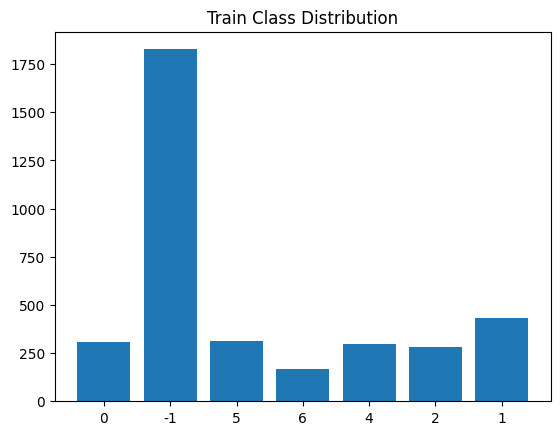

In [17]:
plt.bar(train_label.keys(), train_label.values())
plt.title('Train Class Distribution')
plt.show()

In [18]:
test_label = class_dis('../data/raw/BoneFractureYolo8/test/labels')
test_label

defaultdict(int,
            {'0': 13, '-1': 86, '5': 15, '4': 14, '6': 6, '2': 13, '1': 22})

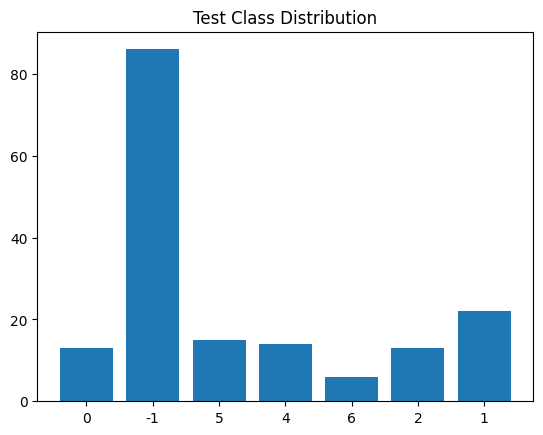

In [19]:
plt.bar(test_label.keys(), test_label.values())
plt.title('Test Class Distribution')
plt.show()

# DATA Processing

In [20]:
def process_dataset(paths, output_dir='../data/processed'):
    valid_ext = ['.png', '.jpg', '.jpeg']
    valid_classes = [str(i) for i in range(7)]
 
    for split, path in paths.items():
        img_dir = os.path.join(path, 'images')
        label_dir = os.path.join(path, 'labels')
        processed_img_dir = os.path.join(output_dir, split, 'images')
        processed_label_dir = os.path.join(output_dir, split, 'labels')
        os.makedirs(processed_img_dir, exist_ok=True)
        os.makedirs(processed_label_dir, exist_ok=True)
        for img_file in tqdm(os.listdir(img_dir), desc=f'Processing {split}'):
            img_path = os.path.join(img_dir, img_file)
            name, ext = os.path.splitext(img_file)
            label_file = f"{name}.txt"
            label_path = os.path.join(label_dir, label_file)
            
            invalid = False
            if ext.lower() not in valid_ext:
                invalid = True
            if not os.path.exists(label_path):
                invalid = True
            else:
                with open(label_path, 'r') as f:
                    content = f.read().strip()
                    if content:
                        first_char = content.split()[0]
                        if first_char not in valid_classes:
                            invalid = True
            if not invalid:
                with Image.open(img_path) as img:
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    resized_img = img.resize((640, 640))
                processed_img_path = os.path.join(processed_img_dir, img_file)
                resized_img.save(processed_img_path)
                shutil.copy2(label_path, os.path.join(processed_label_dir, label_file))


In [21]:
process_dataset(paths)

Processing train:   3%|▎         | 99/3631 [00:01<00:36, 97.49it/s]

Processing test: 100%|██████████| 169/169 [00:01<00:00, 100.26it/s]


In [22]:
# test
x = '../data/processed/train/images/elbow-dislocation-with-coronoid-process-fracture_jpg.rf.75b67d2e40fe637ba2838e1283f970c5.jpg'
y = cv2.imread(x)
print(y.shape)
is_rgb(x)

(640, 640, 3)


True

# Images Visualization

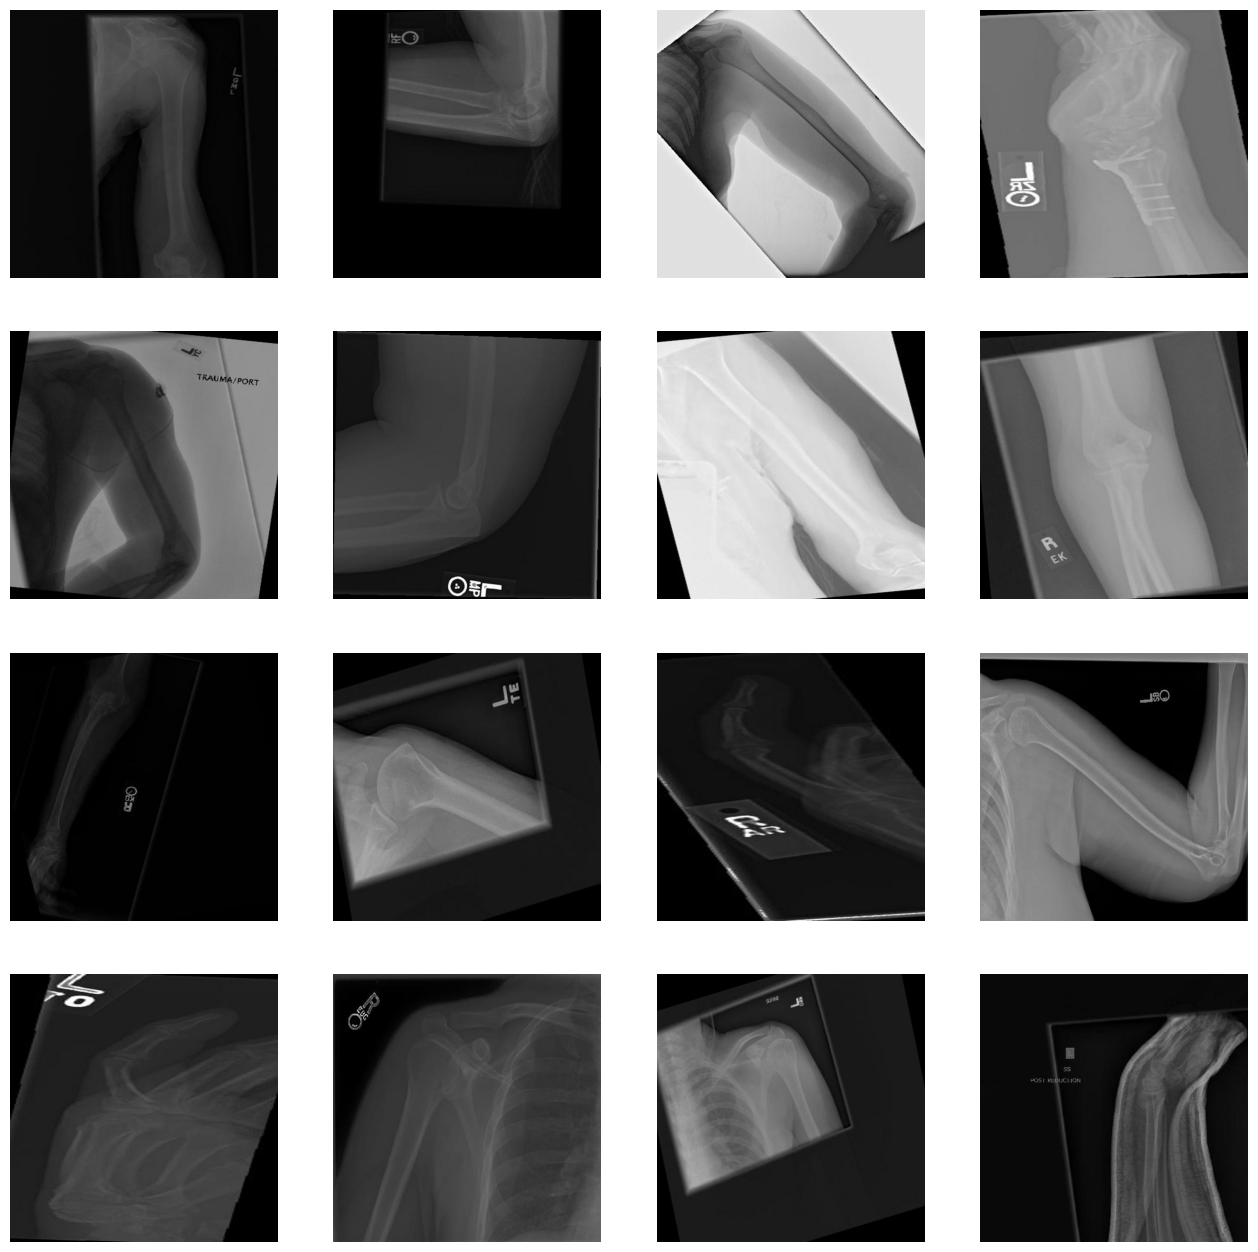

In [23]:
train_imgs = '../data/processed/train/images'
images_file = os.listdir(train_imgs)
random_images = random.sample(images_file, 16)
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    image_path = os.path.join(train_imgs, image_file)
    image = cv2.imread(image_path)
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')
plt.show()

# Model

In [25]:
model = YOLO('yolov8s.pt')
model.train(
    data="../data/processed/data.yaml",
    augment=True, 
    device = 0,
    imgsz=640,
    epochs=50,
    batch=8,
    verbose=True,
    name="bonefracture_yolov8s",
)

New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.145 🚀 Python-3.10.10 torch-2.7.0+cu128 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/processed/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=bonefracture_yolov8s2, nbs=64, nms=False, opset=None, opt

 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2118757  ultralytics.nn.modules.head.Detect           [7, [128, 256, 512]]          
Model summary: 129 layers, 11,138,309 parameters, 11,138,293 gradients, 28.7 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 32.4±14.2 MB/s, size: 20.0 KB)


train: Scanning /teamspace/studios/this_studio/bone-fracture-detection/data/processed/train/labels... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:02<00:00, 1709.07it/s]


train: New cache created: /teamspace/studios/this_studio/bone-fracture-detection/data/processed/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 26.7±23.7 MB/s, size: 15.3 KB)


val: Scanning /teamspace/studios/this_studio/bone-fracture-detection/data/processed/val/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<00:00, 1196.12it/s]


val: New cache created: /teamspace/studios/this_studio/bone-fracture-detection/data/processed/val/labels.cache
Plotting labels to runs/detect/bonefracture_yolov8s2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/bonefracture_yolov8s2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.88G      2.825      8.277      2.488          6        640: 100%|██████████| 454/454 [01:03<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.43it/s]


                   all        348        204    0.00104      0.459    0.00578     0.0015

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.3G      2.693      4.576      2.399          5        640: 100%|██████████| 454/454 [00:58<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.61it/s]

                   all        348        204      0.531     0.0185     0.0208    0.00501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.34G      2.645      4.475      2.408          8        640: 100%|██████████| 454/454 [00:58<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.83it/s]

                   all        348        204      0.504     0.0521     0.0062    0.00149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.38G      2.619      4.269      2.383          6        640: 100%|██████████| 454/454 [00:57<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.07it/s]

                   all        348        204       0.63     0.0172     0.0384     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.41G      2.545      4.088      2.306         11        640: 100%|██████████| 454/454 [00:57<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.77it/s]

                   all        348        204      0.209     0.0439     0.0295    0.00908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.45G      2.494      4.058      2.316          6        640: 100%|██████████| 454/454 [00:57<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.40it/s]

                   all        348        204      0.227     0.0833     0.0395     0.0137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.49G      2.426      3.827      2.284          5        640: 100%|██████████| 454/454 [00:58<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.28it/s]

                   all        348        204      0.584     0.0691     0.0594     0.0196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.52G      2.353      3.655      2.218         10        640: 100%|██████████| 454/454 [00:58<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]

                   all        348        204      0.113     0.0964     0.0723     0.0243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.56G      2.346      3.574      2.206         13        640: 100%|██████████| 454/454 [00:58<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.50it/s]

                   all        348        204      0.391      0.118     0.0945     0.0304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.59G      2.329      3.451      2.216         11        640: 100%|██████████| 454/454 [00:57<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.81it/s]

                   all        348        204      0.336        0.1     0.0944     0.0352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.63G       2.28      3.325      2.171          7        640: 100%|██████████| 454/454 [00:57<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.86it/s]

                   all        348        204      0.154       0.12      0.101     0.0378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.83G      2.252      3.281      2.152          6        640: 100%|██████████| 454/454 [00:57<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.04it/s]

                   all        348        204      0.165      0.168      0.124     0.0457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.87G      2.228      3.216      2.119          6        640: 100%|██████████| 454/454 [00:57<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.06it/s]

                   all        348        204      0.269       0.16      0.122      0.042



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.9G       2.21      3.143      2.101          7        640: 100%|██████████| 454/454 [00:57<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.97it/s]

                   all        348        204      0.199      0.208      0.145     0.0502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.94G      2.162      3.082      2.088          7        640: 100%|██████████| 454/454 [00:57<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.00it/s]

                   all        348        204      0.342      0.146      0.118     0.0412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.97G      2.134       2.94      2.076          8        640: 100%|██████████| 454/454 [00:58<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.12it/s]

                   all        348        204      0.177      0.202       0.14       0.05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.01G      2.105       2.89      2.042          5        640: 100%|██████████| 454/454 [00:58<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.84it/s]

                   all        348        204      0.216        0.2      0.147     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.05G        2.1      2.878      2.022          4        640: 100%|██████████| 454/454 [00:58<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.94it/s]

                   all        348        204      0.313      0.147      0.151     0.0538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.08G       2.08      2.751      2.027          6        640: 100%|██████████| 454/454 [00:58<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.14it/s]

                   all        348        204      0.269      0.197      0.179      0.063



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.12G      2.045        2.7      1.994          7        640: 100%|██████████| 454/454 [00:57<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.70it/s]

                   all        348        204      0.235      0.217      0.169     0.0601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.16G      2.033      2.687          2          3        640: 100%|██████████| 454/454 [00:58<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.15it/s]

                   all        348        204      0.212      0.164      0.169     0.0584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.21G      1.998      2.624      1.943          6        640: 100%|██████████| 454/454 [00:58<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.65it/s]

                   all        348        204      0.221      0.224      0.161     0.0506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.26G       1.96      2.532      1.919          6        640: 100%|██████████| 454/454 [00:58<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.79it/s]

                   all        348        204      0.225      0.177      0.162     0.0596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.34G      1.966      2.456      1.957          4        640: 100%|██████████| 454/454 [00:57<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.60it/s]

                   all        348        204      0.251      0.216      0.174     0.0607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.41G      1.949      2.425      1.911          5        640: 100%|██████████| 454/454 [00:58<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.91it/s]

                   all        348        204      0.208      0.246      0.192     0.0698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.46G      1.927      2.335      1.879          7        640: 100%|██████████| 454/454 [00:58<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.17it/s]

                   all        348        204      0.283       0.28      0.211     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.66G      1.901       2.31      1.869          7        640: 100%|██████████| 454/454 [00:58<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.41it/s]

                   all        348        204      0.247      0.338      0.239     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       3.7G      1.871       2.23      1.848          4        640: 100%|██████████| 454/454 [00:57<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.95it/s]

                   all        348        204      0.277      0.268      0.205     0.0688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.73G      1.841      2.154      1.826          5        640: 100%|██████████| 454/454 [00:58<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.86it/s]

                   all        348        204      0.323      0.244      0.221     0.0753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.77G      1.836      2.122      1.839          3        640: 100%|██████████| 454/454 [00:58<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.66it/s]

                   all        348        204      0.272      0.282      0.227     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       3.8G      1.806      2.067      1.803          5        640: 100%|██████████| 454/454 [00:58<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.96it/s]

                   all        348        204      0.256       0.27      0.208     0.0661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.86G       1.76      2.002       1.77          9        640: 100%|██████████| 454/454 [00:58<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.19it/s]

                   all        348        204      0.362      0.252      0.244     0.0796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.91G      1.728      1.952      1.757          5        640: 100%|██████████| 454/454 [00:58<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.04it/s]

                   all        348        204       0.32      0.274      0.216     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.98G      1.745      1.932      1.752          9        640: 100%|██████████| 454/454 [00:58<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.06it/s]

                   all        348        204      0.283      0.311      0.238      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.04G      1.712      1.828      1.751          4        640: 100%|██████████| 454/454 [00:58<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.10it/s]

                   all        348        204      0.286      0.298      0.223     0.0721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.11G      1.686      1.856      1.706          5        640: 100%|██████████| 454/454 [00:58<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.04it/s]

                   all        348        204      0.293      0.313      0.241     0.0826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.18G      1.655        1.8       1.71          4        640: 100%|██████████| 454/454 [00:58<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.75it/s]

                   all        348        204      0.265      0.276      0.237     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.23G      1.648       1.76      1.688          4        640: 100%|██████████| 454/454 [00:59<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]

                   all        348        204      0.368      0.256      0.255     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.43G      1.611      1.695      1.659         10        640: 100%|██████████| 454/454 [00:58<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.05it/s]

                   all        348        204      0.357      0.239      0.231     0.0831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.47G      1.588      1.659      1.637          3        640: 100%|██████████| 454/454 [00:58<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.89it/s]

                   all        348        204      0.257      0.297       0.24     0.0853


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.51G      1.486      1.443      1.713          6        640: 100%|██████████| 454/454 [00:58<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]

                   all        348        204      0.382      0.234      0.245     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.54G      1.462      1.376      1.691          4        640: 100%|██████████| 454/454 [00:57<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.24it/s]

                   all        348        204      0.269       0.27      0.233      0.078



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.58G      1.444      1.329      1.699          2        640: 100%|██████████| 454/454 [00:57<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.96it/s]

                   all        348        204      0.263      0.271      0.238      0.079



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.78G      1.378      1.233      1.623          2        640: 100%|██████████| 454/454 [00:58<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.21it/s]

                   all        348        204      0.279      0.279      0.241     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.81G      1.342      1.197      1.595          4        640: 100%|██████████| 454/454 [00:57<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.22it/s]

                   all        348        204       0.48      0.245      0.264     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.85G      1.314      1.115      1.566          3        640: 100%|██████████| 454/454 [00:57<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.29it/s]

                   all        348        204      0.386      0.222      0.255      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.88G      1.319        1.1      1.569          2        640: 100%|██████████| 454/454 [00:58<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.03it/s]

                   all        348        204      0.369      0.281      0.251     0.0881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.92G      1.287      1.079      1.565          5        640: 100%|██████████| 454/454 [00:57<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.33it/s]

                   all        348        204      0.342      0.282      0.255     0.0881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.96G      1.249      1.042      1.529          4        640: 100%|██████████| 454/454 [00:57<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.22it/s]

                   all        348        204      0.375      0.253      0.253     0.0895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.01G      1.218     0.9929      1.507          3        640: 100%|██████████| 454/454 [00:58<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.59it/s]

                   all        348        204      0.438      0.216      0.247     0.0929



50 epochs completed in 0.850 hours.
Optimizer stripped from runs/detect/bonefracture_yolov8s2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/bonefracture_yolov8s2/weights/best.pt, 22.5MB

Validating runs/detect/bonefracture_yolov8s2/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.10.10 torch-2.7.0+cu128 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:05<00:00,  3.99it/s]


                   all        348        204      0.397      0.289      0.285     0.0998
        elbow positive         28         29       0.21      0.172     0.0796     0.0261
      fingers positive         41         48      0.704      0.198      0.305     0.0888
      forearm fracture         37         43      0.536       0.43      0.447      0.172
               humerus         31         36      0.522      0.611      0.647       0.21
     shoulder fracture         19         20      0.272       0.25      0.166     0.0691
        wrist positive         17         28      0.139     0.0714     0.0666     0.0332
Speed: 0.3ms preprocess, 13.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/bonefracture_yolov8s2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f1d90852f20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [26]:
model = YOLO("runs/detect/bonefracture_yolov8s2/weights/best.pt")

In [27]:
metrics = model.val()


print(f"mAP50: {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP50-95: {metrics.results_dict['metrics/mAP50-95(B)']:.4f}")
print(f"Precision: {metrics.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {metrics.results_dict['metrics/recall(B)']:.4f}")


Ultralytics 8.3.145 🚀 Python-3.10.10 torch-2.7.0+cu128 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 869.5±324.6 MB/s, size: 19.4 KB)


val: Scanning /teamspace/studios/this_studio/bone-fracture-detection/data/processed/val/labels.cache... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.53it/s]


                   all        348        204      0.474      0.245      0.265     0.0917
        elbow positive         28         29      0.201      0.138     0.0973     0.0347
      fingers positive         41         48       0.82      0.188      0.281     0.0823
      forearm fracture         37         43       0.62      0.395      0.432      0.165
               humerus         31         36      0.689      0.528      0.563      0.171
     shoulder fracture         19         20      0.327       0.15      0.168     0.0728
        wrist positive         17         28      0.186     0.0714     0.0494     0.0248
Speed: 1.0ms preprocess, 8.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val

Validation Metrics:
mAP50: 0.2652
mAP50-95: 0.0917
Precision: 0.4738
Recall: 0.2450


In [32]:
Path = '../data/processed/val/images/image1_7_png.rf.4d60e88297d0349d04e0f8ea0189df34.jpg'

results = model.predict(Path, conf=0.25, iou=0.45)


image 1/1 /teamspace/studios/this_studio/bone-fracture-detection/src/../data/processed/val/images/image1_7_png.rf.4d60e88297d0349d04e0f8ea0189df34.jpg: 640x640 (no detections), 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


In [33]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'elbow positive', 1: 'fingers positive', 2: 'forearm fracture', 3: 'humerus fracture', 4: 'humerus', 5: 'shoulder fracture', 6: 'wrist positive'}
 obb: None
 orig_img: array([[[182, 182, 182],
         [182, 182, 182],
         [182, 182, 182],
         ...,
         [ 38,  38,  38],
         [ 32,  32,  32],
         [ 28,  28,  28]],
 
        [[182, 182, 182],
         [182, 182, 182],
         [182, 182, 182],
         ...,
         [ 39,  39,  39],
         [ 32,  32,  32],
         [ 28,  28,  28]],
 
        [[182, 182, 182],
         [182, 182, 182],
         [182, 182, 182],
         ...,
         [ 39,  39,  39],
         [ 33,  33,  33],
         [ 28,  28,  28]],
 
        ...,
 
        [[192, 192, 192],
         [192, 192, 192],
         [192, 192, 192],
         ...,
         [194, 194, 194],
         [194, 194, 194],
   